Import

In [35]:
# %pip install pydicom
# %pip install pylibjpeg
# %pip install python_gdcm
# %pip install opencv-python
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install torch
# %pip install torchvision
# %pip install albumentations
# %pip install efficientnet_pytorch
%pip install transformers
%pip install -q datasets transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pydicom
import pylibjpeg
import gdcm
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from IPython.display import display_html

Load Patient Info

In [ ]:
# path = '/Volumes/Seagate Portable Disk/University of Manitoba/Data Science/Datasets/RSNA Breast Cancer/rsna-breast-cancer-detection'
path = '.'
train_img_path = f'{path}/train_images'

train_df = pd.read_csv(f'{path}/train.csv')
train_df

Training data info

- site_id       : [1,2] 2 Sites, 29K-25K
- patient_id    : Some patients with up to 14 images
- image_id      : unique
- laterality    : [L or R], 50-50
- view          : ['MLO' 'CC' 'AT' 'LM' 'ML', +1], Mostly MLO and CC
- age           : [min = 26, median = 59, max = 89]
- **cancer**        : [0,1] 2% (1.1K) have cancer
- biopsy        : [0,1] 6% (3K) have biopsy
- invasive      : [0,1] 800 cases
- BIRADS        : [0,1,2,nan]
- implant       : [0,1] 2% (1.5K) have implant
- density       : [A,B,C,D,nan] Half is Nan, around 12K for B,C, 3K for A and 1.5K for D
- machine_id    : 10 machines, ~1/2 from {49}, ~1/2 from {48,29,21}
- difficult_negative_case : 7.7K are difficult negative cases

Missing values:
- density and BIRADS are half full
- 37 records with missing age

In [ ]:
def get_files(folder):
    fnames = sorted(next(os.walk(folder), (None, None, []))[2])
    fpaths = [f"{folder}/{fname}" for fname in fnames]
    return fnames,fpaths

def get_folders(parent):
    fnames = sorted(next(os.walk(parent), (None, [], None))[1])
    fpaths = [f"{parent}/{fname}" for fname in fnames]
    return fnames,fpaths

def profile(dataframe,missing_values = []) -> pd.DataFrame:
    """
    Summary table for each columns in the dataframe
    """
    dataframe = pd.DataFrame(dataframe)
    ncols = len(dataframe.columns)
    nrows = len(dataframe)
    pf = pd.DataFrame(index = dataframe.columns, columns=["dtype","count","missing","fill_pct","unique","top5_samples","top5_samples_cnt","mode","min","max","median","mean","std"], dtype=object)
    pf.index.name = "column"
    for col_name in dataframe.columns:
        col_vals = dataframe[col_name]
        col_vals_nonempty = col_vals[col_vals != missing_values] if missing_values else col_vals[col_vals.notna()]
        top5_samples = col_vals.value_counts(ascending=False,dropna=False).iloc[:5]
        pf.loc[col_name,"dtype"]     = col_vals.dtype.__str__()
        pf.loc[col_name,"count"]    = col_vals.notna().sum()
        pf.loc[col_name,"unique"]   = len(col_vals.unique())
        pf.loc[col_name,"missing"]  = len(col_vals) - len(col_vals_nonempty)
        pf.loc[col_name,"fill_pct"] = np.round(len(col_vals_nonempty)/nrows,2)
        pf.loc[col_name,"top5_samples"] = str(top5_samples.index.values)
        pf.loc[col_name,"top5_samples_cnt"] = str(top5_samples.values)
        pf.loc[col_name,"mode"] = str(col_vals.mode().values)
        if pf.loc[col_name,"dtype"].startswith(("int","float")):
            pf.loc[col_name,"min"] = np.min(col_vals_nonempty)
            pf.loc[col_name,"max"] = np.max(col_vals_nonempty)
            pf.loc[col_name,"mean"] = np.round(np.mean(col_vals_nonempty),1)
            pf.loc[col_name,"median"] = np.round(np.median(col_vals_nonempty),1)
            pf.loc[col_name,"std"] = np.round(np.std(col_vals_nonempty),1)
    pf = pf.reset_index()
    return pf

profile(train_df)

In [ ]:
test_df = pd.read_csv(f'{path}/test.csv')
test_df

Further EDA

In [ ]:
# Load a patient
cancer_negative_imgs = (train_df['cancer']==0)
cancer_positive_imgs = (train_df['cancer']==1)
diff_cancer_neg_imgs = (train_df['difficult_negative_case']==True)

# sample_cancer_neg_patient = (train_df['patient_id'] == train_df.loc[cancer_negative_imgs,'patient_id'].sample(1,random_state=1).item())
# sample_cancer_pos_patient = (train_df['patient_id'] == train_df.loc[cancer_positive_imgs,'patient_id'].sample(1,random_state=1).item())
# sample_diff_neg_patient = (train_df['patient_id'] == train_df.loc[diff_cancer_neg_imgs,'patient_id'].sample(1,random_state=1).item())

sample_cancer_neg_patient = train_df['patient_id'] == 11294 
sample_cancer_pos_patient = train_df['patient_id'] == 10130
sample_diff_neg_patient = train_df['patient_id'] == 1154

In [ ]:
# a = train_df[train_df['difficult_negative_case']==True].value_counts('patient_id',ascending=False)
# a[a<=6]

In [ ]:
train_df.loc[sample_cancer_neg_patient] 

In [ ]:
train_df.loc[sample_cancer_pos_patient]

In [ ]:
train_df.loc[sample_diff_neg_patient]

#patients with only neg imgs =  11427 

#patients with only pos imgs =  6

#patients with both neg and pos imgs = 480

Load Images

Original Dataset

In [ ]:
def read_img(path, n_channels = 1):
    if path.endswith('.dcm'):
        img = pydicom.dcmread(path).pixel_array
    else:
        img = np.array(Image.open(path))
    if img.shape[0] < n_channels:
        img = np.tile(img, (n_channels,1,1))
    return img
# def read_dcm(path):
#     return pydicom.dcmread(path).pixel_array

def plot_img(img,ax=plt,cmap='turbo'):
    ax.axis("off")
    ax.imshow(img, cmap=cmap)

def plot_patient(patient_id,path):
    patient_info = train_df[train_df['patient_id'] == patient_id]
    nrows = len(patient_info)//5 + 1
    ncols = 5
    fig, axs = plt.subplots(nrows, ncols, figsize=(min(20,ncols*5),nrows*5))
    plt.subplots_adjust(hspace=0.7)
    axs = axs.flatten()
    for ax in axs:
        ax.axis("off")
    for k,(_,img_row) in enumerate(patient_info.iterrows()):
        img = read_img(f'{path}/{patient_id}/{img_row["image_id"]}.dcm')
        plot_img(img,ax=axs[k])
        axs[k].set_title(f"{img_row.drop(['site_id','patient_id','machine_id'])}",fontsize = 8, weight=None,y=-0.60)


patient_id = 11294
plot_patient(patient_id,train_img_path)

In [ ]:
patient_id = 10130
plot_patient(patient_id,train_img_path)

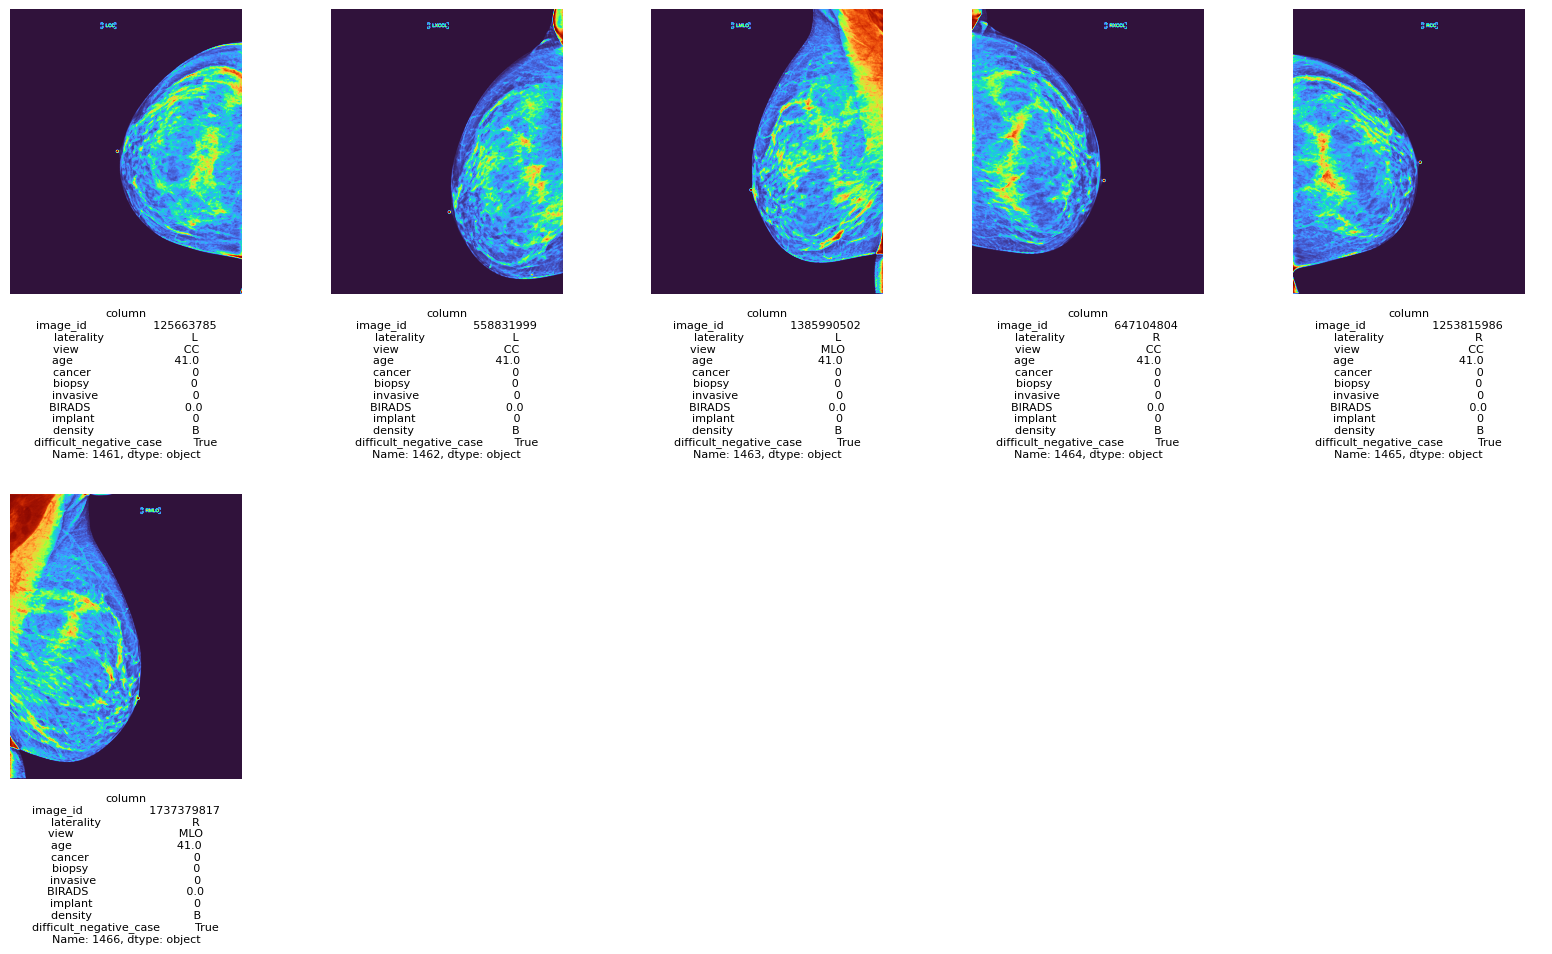

In [13]:
patient_id = 1154
plot_patient(patient_id,train_img_path)

## 256px Dataset

Original image resolution

(3328, 2560) [0, 4095]


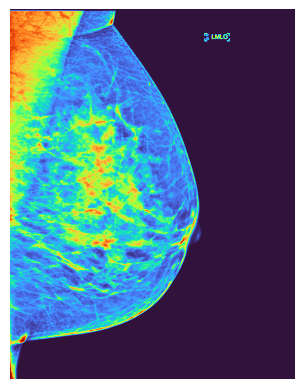

In [14]:
patient_id = 11294
image_id = 812228127
img_path_dcm = f'{train_img_path}/{patient_id}/{image_id}.dcm'
img = read_img(img_path_dcm)
print(img.shape,[img.min(),img.max()])
plot_img(img)

Resized image (from https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-256-pngs)

(256, 256) [0, 255]


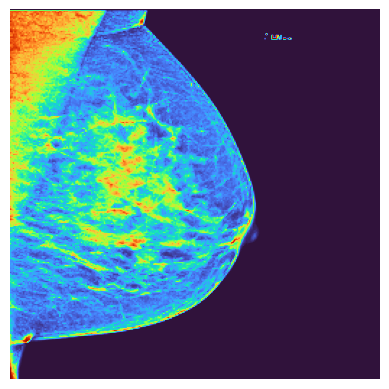

In [15]:
img_path_png = f'256px/{patient_id}_{image_id}.png'
img = np.array(Image.open(img_path_png))
print(img.shape,[img.min(),img.max()])
plot_img(img)

## Data Preprocessing

In [16]:
train_df['laterality'] = LabelEncoder().fit_transform(train_df['laterality'])
train_df['view'] = LabelEncoder().fit_transform(train_df['view'])
train_df['density'] = LabelEncoder().fit_transform(train_df['density'])
train_df['difficult_negative_case'] = train_df['difficult_negative_case'].astype(float)
train_df['path'] = f"{path}/256px/" + train_df['patient_id'].astype(str) + "_" + train_df['image_id'].astype(str) + ".png"
train_df['BIRADS'] = train_df['BIRADS'].fillna(-1)
train_cols = train_df.columns.drop(['site_id','machine_id'])	
train_df = train_df[train_cols]
train_df

column,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,path
0,10006,462822612,0,1,61.0,0,0,0,-1.0,0,4,0.0,./256px/10006_462822612.png
1,10006,1459541791,0,5,61.0,0,0,0,-1.0,0,4,0.0,./256px/10006_1459541791.png
2,10006,1864590858,1,5,61.0,0,0,0,-1.0,0,4,0.0,./256px/10006_1864590858.png
3,10006,1874946579,1,1,61.0,0,0,0,-1.0,0,4,0.0,./256px/10006_1874946579.png
4,10011,220375232,0,1,55.0,0,0,0,0.0,0,4,1.0,./256px/10011_220375232.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,0,0,1.0,0,2,0.0,./256px/9973_1729524723.png
54702,9989,63473691,0,5,60.0,0,0,0,-1.0,0,2,0.0,./256px/9989_63473691.png
54703,9989,1078943060,0,1,60.0,0,0,0,-1.0,0,2,0.0,./256px/9989_1078943060.png
54704,9989,398038886,1,5,60.0,0,0,0,0.0,0,2,1.0,./256px/9989_398038886.png


## Data Subset Sampling

Make sure the computer doesn't explode : )

In [17]:
def sample(df,n,random_state,dropna=True):
    sampled_df = pd.DataFrame()
    remaining_df = df.copy().dropna() if dropna else df.copy()
    for col in remaining_df.columns:
        for val in pd.unique(remaining_df[col]):
            if pd.isna(val):
                df_col = remaining_df[remaining_df[col].isna()]
            else:
                df_col = remaining_df[remaining_df[col] == val]
            sampled = df_col.sample(min(n,len(df_col)),random_state=random_state,replace=False)
            sampled_df = pd.concat([sampled_df,sampled])
            remaining_df = remaining_df.loc[remaining_df.index.difference(sampled_df.index)]
    return sampled_df.drop_duplicates()

train_rows = sample(train_df[train_cols.drop(['patient_id','image_id','age','path'])],n=3,random_state=42,dropna=True).index
# train_samples = train_df.loc[train_rows]
data_samples = train_df.set_index(['patient_id','laterality']).loc[train_df.loc[train_rows,'patient_id']].reset_index()
# train_samples.to_csv('train_samples_1.csv')
data_samples

column,patient_id,laterality,image_id,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,path
0,5698,0,508015262,5,57.0,0,0,0,0.0,0,1,1.0,./256px/5698_508015262.png
1,5698,0,661831208,1,57.0,0,0,0,0.0,0,1,1.0,./256px/5698_661831208.png
2,5698,0,1083274745,1,57.0,0,0,0,0.0,0,1,1.0,./256px/5698_1083274745.png
3,5698,0,1888447274,5,57.0,0,0,0,0.0,0,1,1.0,./256px/5698_1888447274.png
4,5698,1,250593308,5,57.0,0,0,0,-1.0,0,1,0.0,./256px/5698_250593308.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,7445,1,1010089340,1,67.0,0,0,0,2.0,0,0,0.0,./256px/7445_1010089340.png
300,55763,0,1691058458,5,61.0,0,0,0,0.0,0,1,1.0,./256px/55763_1691058458.png
301,55763,0,1954720347,1,61.0,0,0,0,0.0,0,1,1.0,./256px/55763_1954720347.png
302,55763,1,1228294174,5,61.0,0,0,0,-1.0,0,1,0.0,./256px/55763_1228294174.png


In [18]:
profile(data_samples)

,column,dtype,count,missing,fill_pct,unique,top5_samples,top5_samples_cnt,mode,min,max,median,mean,std
0,patient_id,int64,304,0,1.0,55,[34380 54713 17604 24398 5880],[10 9 9 8 8],[34380],1511,65382,27995.0,29297.4,17489.2
1,laterality,int64,304,0,1.0,2,[1 0],[154 150],[1],0,1,1.0,0.5,0.5
2,image_id,int64,304,0,1.0,304,[ 508015262 1555569551 811924383 1943278681 1...,[1 1 1 1 1],[ 4596707 4771598 38304149 44080732 ...,4596707,2129134142,1098582160.0,1090892992.6,595617800.0
3,view,int64,304,0,1.0,6,[1 5 0 2 4],[145 144 5 5 4],[1],0,5,2.0,2.9,2.0
4,age,float64,304,0,1.0,32,[57. 65. 62. 70. 72.],[18 18 18 17 16],[57. 62. 65.],40.0,86.0,62.0,61.3,11.1
5,cancer,int64,304,0,1.0,2,[0 1],[281 23],[0],0,1,0.0,0.1,0.3
6,biopsy,int64,304,0,1.0,2,[0 1],[256 48],[0],0,1,0.0,0.2,0.4
7,invasive,int64,304,0,1.0,2,[0 1],[285 19],[0],0,1,0.0,0.1,0.2
8,BIRADS,float64,304,0,1.0,4,[-1. 1. 0. 2.],[99 91 71 43],[-1.],-1.0,2.0,0.0,0.3,1.1
9,implant,int64,304,0,1.0,2,[0 1],[270 34],[0],0,1,0.0,0.1,0.3


<Axes: ylabel='Frequency'>

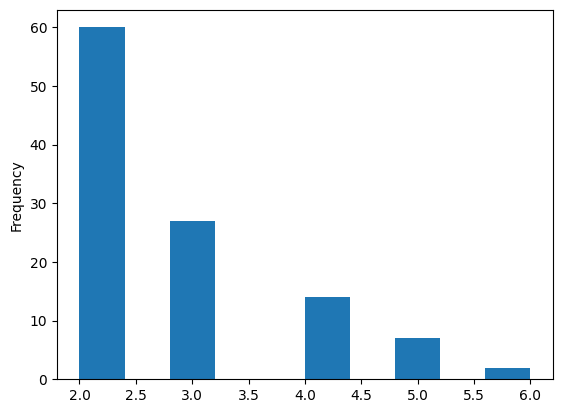

In [19]:
data_samples.value_counts(['patient_id','laterality']).plot.hist()

# Baseline Models

Courtesy of https://www.kaggle.com/code/andradaolteanu/rsna-breast-cancer-eda-pytorch-baseline

EfficientNet: https://github.com/lukemelas/EfficientNet-PyTorch

- Train a model for top and side scans
- Generate four probabilities per patient
- Use that with a nn to generate predictions
- Finetune the entire thing together
- Pure training of resnet/vit on side and top scans 
- Freeze resnets/vits, and train neural network to predict whether cancer is there using the 4 predictions from resnets/vits, and the tabular data on the pateitn
- Finetune both 

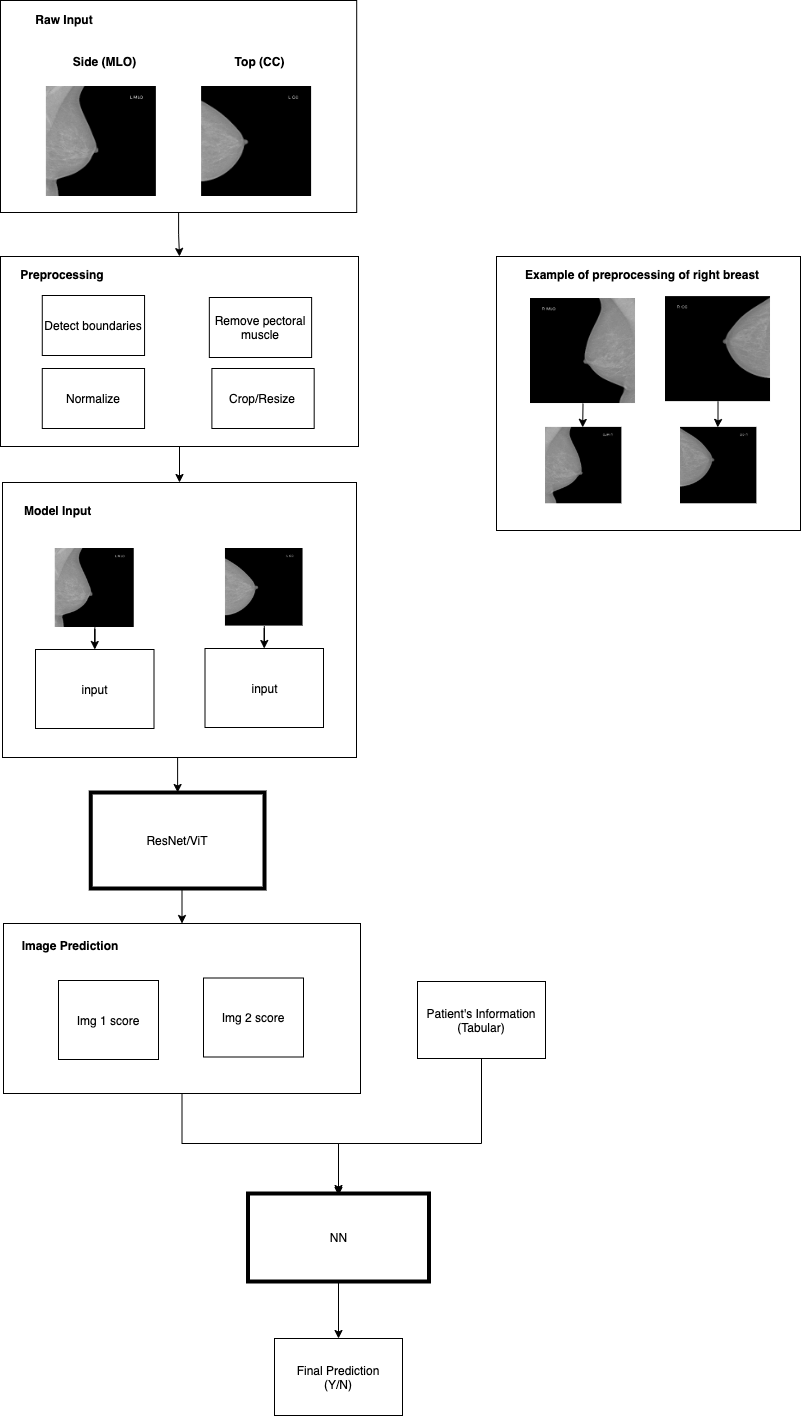

In [20]:
Image.open('./architecture.png')

In [21]:
data_samples = pd.read_csv('train_samples_1.csv').set_index('Unnamed: 0')
data_samples.index.name = 'index'
data_samples

,patient_id,laterality,image_id,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,path
index,,,,,,,,,,,,,
0,5698,0,508015262,5,57.0,0,0,0,0.0,0,1,1.0,./256px/5698_508015262.png
1,5698,0,661831208,1,57.0,0,0,0,0.0,0,1,1.0,./256px/5698_661831208.png
2,5698,0,1083274745,1,57.0,0,0,0,0.0,0,1,1.0,./256px/5698_1083274745.png
3,5698,0,1888447274,5,57.0,0,0,0,0.0,0,1,1.0,./256px/5698_1888447274.png
4,5698,1,250593308,5,57.0,0,0,0,-1.0,0,1,0.0,./256px/5698_250593308.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,7445,1,1010089340,1,67.0,0,0,0,2.0,0,0,0.0,./256px/7445_1010089340.png
300,55763,0,1691058458,5,61.0,0,0,0,0.0,0,1,1.0,./256px/55763_1691058458.png
301,55763,0,1954720347,1,61.0,0,0,0,0.0,0,1,1.0,./256px/55763_1954720347.png


In [22]:
from sklearn.model_selection import train_test_split

train_samples, test_samples = train_test_split(data_samples, 
                                               test_size = 0.2, 
                                               stratify = data_samples['cancer'])

display_html(train_samples)
display_html(test_samples)

,patient_id,laterality,image_id,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,path
index,,,,,,,,,,,,,
246,5880,0,716477060,5,70.0,0,0,0,1.0,1,0,0.0,./256px/5880_716477060.png
136,17604,0,1107269971,1,70.0,0,0,0,1.0,1,1,0.0,./256px/17604_1107269971.png
126,31477,1,2056832119,5,49.0,0,0,0,1.0,0,2,0.0,./256px/31477_2056832119.png
162,65382,0,992411918,5,44.0,0,0,0,2.0,0,2,0.0,./256px/65382_992411918.png
172,27153,0,1494759482,1,72.0,0,0,0,-1.0,0,4,0.0,./256px/27153_1494759482.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1511,0,1760744211,4,63.0,0,0,0,0.0,0,2,1.0,./256px/1511_1760744211.png
255,30052,0,1683139460,5,40.0,0,0,0,-1.0,0,2,0.0,./256px/30052_1683139460.png
283,52390,1,443373457,1,60.0,0,0,0,1.0,0,1,0.0,./256px/52390_443373457.png


,patient_id,laterality,image_id,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,path
index,,,,,,,,,,,,,
237,17752,0,898706277,1,65.0,0,0,0,1.0,1,2,0.0,./256px/17752_898706277.png
48,52148,1,222325597,5,58.0,0,0,0,-1.0,0,2,0.0,./256px/52148_222325597.png
234,54713,1,1507749602,1,48.0,0,0,0,1.0,1,2,0.0,./256px/54713_1507749602.png
18,7412,0,1378096953,1,78.0,0,0,0,-1.0,0,1,0.0,./256px/7412_1378096953.png
182,28620,1,685239979,1,55.0,1,1,1,0.0,0,2,0.0,./256px/28620_685239979.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,5878,1,872782383,5,72.0,1,1,1,0.0,0,1,0.0,./256px/5878_872782383.png
141,17604,1,313119290,1,70.0,0,0,0,1.0,1,1,0.0,./256px/17604_313119290.png
180,28620,0,851591267,5,55.0,0,0,0,-1.0,0,2,0.0,./256px/28620_851591267.png


# Pipeline

PyTorch

In [23]:
# PyTorch
import gc

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
from time import time
import datetime as dtime
from tqdm import tqdm
# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


Dataset

In [24]:
class RSNADataset(Dataset):
    def __init__(self,dataframe, vertical_flip=0.5, horizontal_flip=0.5,is_train=True) -> None:
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([RandomResizedCrop(height=224, width=224),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      ToTensorV2()])
        else:
            self.transform = Compose([ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self,index):
        image_path = self.dataframe.iloc[index]['path']
        # X = torch.tensor(read_img(image_path)).unsqueeze(0).tile((3,1,1)).type(torch.float32)
        X = read_img(image_path).astype(np.float32)
        X_trf = self.transform(image = X)['image'].tile((3,1,1))
        y = self.dataframe.iloc[index]['cancer']
        return X_trf,y

data = train_samples
dataset = RSNADataset(data, vertical_flip=0.5, horizontal_flip=0.5,
                      is_train=True)
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

In [25]:
test_dataset = RSNADataset(test_samples,is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
X,y = next(iter(test_dataloader))

# test_dataset.dataframe['cancer'].value_counts()
y.shape

torch.Size([61])

ResNet Module

In [26]:
class ResNet50(nn.Module):
    def __init__(self,output_size=1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        self.classification = nn.Linear(1000, output_size)

    def forward(self,X):
        X_embeddings = self.features(X)
        output = self.classification(X_embeddings)
        return output
    
    def predict(self,X,proba=False):
        self.eval()
        out = self.forward(X)
        if proba:
            return torch.sigmoid(out).squeeze().numpy()
        else:
            return torch.round(torch.sigmoid(out)).squeeze().numpy()

# dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
# X,y = next(iter(dataloader))
# model = ResNet50(output_size=1)
# out = model.forward(X)
# out

In [27]:
# model.predict(X)

In [28]:
def train_model(model,data):
    vertical_flip = 0.5
    horizontal_flip = 0.5

    FOLDS = 3
    EPOCHS = 10
    PATIENCE = 5
    WORKERS = 8
    LR = 0.0005
    WD = 0.0
    LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
    LR_FACTOR = 0.4            # by how much the lr is decreasing

    BATCH_SIZE1 = 16           # for train
    BATCH_SIZE2 = 8           # for valid

    patience_f = PATIENCE


    group_fold = StratifiedGroupKFold(n_splits = FOLDS)
    k_folds = group_fold.split(X = np.zeros(len(data)), 
                                y = data['cancer'], 
                                groups = data['patient_id'].tolist())

    for i, (train_index, valid_index) in enumerate(k_folds):
        best_roc = None
        # Reset patience before every fold
        patience_f = PATIENCE

        # Optimizer/ Scheduler/ Criterion
        optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=LR_PATIENCE, verbose=True, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss()

        train_data = data.iloc[train_index].reset_index(drop=True)
        valid_data = data.iloc[valid_index].reset_index(drop=True)
        train = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
        valid = RSNADataset(valid_data, vertical_flip, horizontal_flip, is_train=True)
        train_loader = DataLoader(train, batch_size=BATCH_SIZE1, shuffle=True ) # num_workers=WORKERS
        valid_loader = DataLoader(valid, batch_size=BATCH_SIZE2, shuffle=False) # num_workers=WORKERS

        # === EPOCHS ===
        for epoch in range(EPOCHS):
            start_time = time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            model.train()
            desc = f"Epoch {epoch+1}/{EPOCHS} - training"
            tqdm_loader = tqdm(enumerate(train_loader),total=len(train_loader),desc = desc, unit = f'batch-of-{BATCH_SIZE1}')
            for k, (X,y) in tqdm_loader:
                # Save them to device
                # Clear gradients first; very important
                # usually done BEFORE prediction
                optimizer.zero_grad()
                # Log Probabilities & Backpropagation
                out = model(X)
                loss = criterion(out, y.unsqueeze(1).float())
                loss.backward()
                optimizer.step()

                train_losses += loss.item()
                # From log probabilities to actual probabilities
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                # Number of correct predictions
                correct += (train_preds == y.unsqueeze(1)).sum().item()
                
            train_acc = correct / len(train_index)
            # print({"train_acc": train_acc})

            # === EVAL ===
            # Sets the model in evaluation mode.
            model.eval()
            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1), dtype=torch.float32)

            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                desc = f"Epoch {epoch+1}/{EPOCHS} - validation"
                tqdm_loader = tqdm(enumerate(valid_loader),total=len(valid_loader),desc=desc, unit = f'batch-of-{BATCH_SIZE2}')
                for k, (X,y) in tqdm_loader:
                    # Save them to device
                    out = model(X)
                    pred = torch.sigmoid(out)
                    valid_preds[k*X.shape[0] : k*X.shape[0] + X.shape[0]] = pred

                # Calculate accuracy
                valid_acc = accuracy_score(valid_data['cancer'].values, torch.round(valid_preds.cpu()))
                # Calculate ROC
                valid_roc = roc_auc_score(valid_data['cancer'].values, valid_preds.cpu())

                # Calculate time on Train + Eval
                duration = str(dtime.timedelta(seconds=time() - start_time))[:7]


                # PRINT INFO
                final_logs = '{} | Epoch: {}/{} | Loss: {:.4} | Acc_tr: {:.3} | Acc_vd: {:.3} | ROC: {:.3}'.\
                                format(duration, epoch+1, EPOCHS, 
                                        train_losses, train_acc, valid_acc, valid_roc)
                print(final_logs)

                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)
                # Name the model
                model_name = f"Fold{i+1}_Epoch{epoch+1}_ValidAcc{valid_acc:.3f}_ROC{valid_roc:.3f}.pth"

                # Update best_roc
                if best_roc is None: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(), model_name)
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = PATIENCE
                    torch.save(model.state_dict(), model_name)
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        stop_logs = 'Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                    format(best_roc)
                        print(stop_logs)
                        break
        del X,y,train_data,valid_data,train,valid,train_loader,valid_loader
        gc.collect()

model = ResNet50(output_size=1)
# train_model(model,train_samples)

/Users/jasetran/Library/CloudStorage/OneDrive-UniversityofManitoba/Projects/rsna-cancer-detection-1/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jasetran/Library/CloudStorage/OneDrive-UniversityofManitoba/Projects/rsna-cancer-detection-1/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
from sklearn.metrics import *

def test_model(model,test_data):
    test_dataset = RSNADataset(test_data,is_train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    X,y = next(iter(test_dataloader))
    y_true = y.numpy().astype(int)
    y_pred = model.predict(X)

    print(f1_score(y_true,y_pred))
    print(accuracy_score(y_true,y_pred))

    return y_true,y_pred
    # test_dataset.dataframe['cancer'].value_counts()

# model.load_state_dict(torch.load('Fold1_Epoch8_ValidAcc0.936_ROC0.770.pth'))

# y_true,y_pred = test_model(model,data_samples[data_samples['cancer'] == 1])

Idea 1: 
Actually alter the images according to the tabular data, either by changing the whole thing or adding in our own custom made patches according to features

Idea 2: 
Learn to predict whether a scan is a contentious case. Produce one classifier for standard images, and another for contentious ones.

Idea 3:
Generate outputs and predict on the outputs and tabular data with an nn 
I think we can honestly run all three because there will be heavy heavy code reuse
and I don't mine paying for some compute
Idea 1 is really interesting to me right now

# Idea 1

In [32]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [33]:
configuration

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.27.4"
}

In [34]:
from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

ModuleNotFoundError: No module named 'datasets'